# Exploration

In [583]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import math
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [584]:
raw = pd.read_csv("data/Nov2007-June2009.csv").to_numpy()

In [585]:
def clean(raw):
    for i in range(len(raw)):
        for j in range(1,len(raw[0])):
            raw[i][j] = float(raw[i][j].replace(",", ""))
clean(raw)
raw

array([['07/01/2009', 925.03, 931.92, 920.82, 923.33],
       ['06/30/2009', 926.79, 930.01, 912.86, 919.32],
       ['06/29/2009', 916.0, 927.99, 916.18, 927.23],
       ...,
       ['11/05/2007', 1502.17, 1510.84, 1489.95, 1502.17],
       ['11/02/2007', 1509.65, 1513.15, 1492.53, 1509.65],
       ['11/01/2007', 1508.44, 1545.79, 1506.66, 1508.44]], dtype=object)

In [586]:
df = pd.DataFrame(raw, columns=["Date","Open","High","Low","Close"])

In [587]:
def str_to_datetime(s):
    split = s.split('/')
    month, day, year = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(day= day, month=month, year=year)

df["Date"] = df["Date"].apply(str_to_datetime)

In [588]:
# def window(dataframe, first_date, last_date, n = 3):
#     first = str_to_datetime(first_date)
#     last = str_to_datetime(last_date)

#     target_date = first

#     dates = []
#     X, Y = [], []
    
#     last_time = False
#     while True:
#         df_subset = dataframe.loc[:target_date].tail(n+1)
#         if len(df_subset) != n+1:
#             print(f"Error: Window of size{n} is too large")
#             return
        
#         values = df_subset["Close"].to_numpy()
#         x, y = values[:-1], values[-1]

#         dates.append(target_date)
#         X.append(x)
#         Y.append(y)

#         # next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=2)]
#         next_week = dataframe.loc[:target_date].tail(2)
#         next_datetime = str(next_week.head(2).tail(1).index.values[0])
#         next_date_str = next_datetime.split("T")[0]
#         year_month_day = next_date_str.split('-')
#         year, month, day = year_month_day
#         next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

#         if last_time:
#             break
#         target_date = next_date
#         if target_date == last_date:
#             last_time = True

#         ret_df = pd.DataFrame({})
#         ret_df["Target Date"] = dates

#         X = np.array(X)
#         for i in range(0, n):
#             X[:, i]
#             ret_df[f'Target-{n-1}'] = X[:, i]
#         ret_df['Target'] = Y
#         return ret_df
# windowed = window(df, '11/01/2007', '07/01/2009', n=3)
# windowed

In [589]:
df = df.drop(["Open", "High", "Low"], axis= 1)
n = 3
for i in range(1, n+1):
    df[f"Target-{i}"] = df["Close"].shift(-(i))
df = df.drop([416,417,418])

In [590]:
df

,Date,Close,Target-1,Target-2,Target-3
0,2009-07-01,923.33,919.32,927.23,918.9
1,2009-06-30,919.32,927.23,918.9,920.26
2,2009-06-29,927.23,918.9,920.26,900.94
3,2009-06-26,918.9,920.26,900.94,895.1
4,2009-06-25,920.26,900.94,895.1,893.04
...,...,...,...,...,...
411,2007-11-12,1439.18,1453.7,1474.77,1475.62
412,2007-11-09,1453.7,1474.77,1475.62,1520.27
413,2007-11-08,1474.77,1475.62,1520.27,1502.17
414,2007-11-07,1475.62,1520.27,1502.17,1509.65


In [591]:
def window_to_np(dataframe):
    np_df = dataframe.to_numpy()
    # get all the rows but just the first column
    dates = np_df[:, 0]

    input = np_df[:, 2:]
    # 1 bc only one variable
    x = input.reshape((len(dates), input.shape[1], 1))
    # check Y
    y = np_df[:,1]
    return dates, x.astype(np.float32), y.astype(np.float32)

dates, x, y = window_to_np(df)
dates.shape, x.shape, y.shape

((416,), (416, 3, 1), (416,))

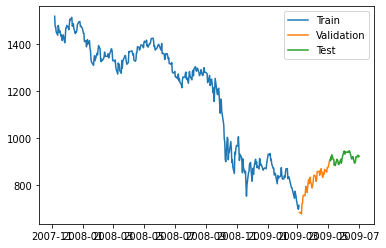

In [592]:
# q_80 = int(len(dates) * .8)
# q_90 = int(len(dates) * .9)

# dates_train, X_train, y_train = dates[:q_80], X[:q_80], Y[:q_80]
# dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], Y[q_80:q_90]
# dates_test, X_test, y_test = dates[q_90:], X[q_90:], Y[q_90:]

q_10 = int(len(dates) * .1)
q_20 = int(len(dates) * .2)

dates_train, x_train, y_train = dates[q_20:], x[q_20:], y[q_20:]
dates_val, x_val, y_val = dates[q_10:q_20], x[q_10:q_20], y[q_10:q_20]
dates_test, x_test, y_test = dates[:q_10], x[:q_10], y[:q_10]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])


<AxesSubplot:xlabel='Date'>

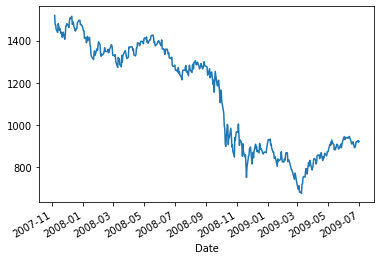

In [593]:
# remove most left column
new_df = df.copy()
new_df.index = new_df.pop("Date")
# plt.plot(new_df.index, df["Close"])
# df.index
original = new_df["Close"].plot()
original

In [595]:
# 3, 1 because 3 days look back and 1 for 1 variable
model = Sequential([layers.Input((3,1)),
# the bigger the number, the more complicated, the more likely it is to overfit
                    layers.LSTM(64),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(32, activation = 'relu'),
                    # default is linear
                    layers.Dense(1)])

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 100)


Epoch 1/100
11/11 [==============================] - 3s 57ms/step - loss: 1491426.5000 - mean_absolute_error: 1198.7869 - val_loss: 663622.3125 - val_mean_absolute_error: 812.7095
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1490336.2500 - mean_absolute_error: 1198.3330 - val_loss: 662823.3125 - val_mean_absolute_error: 812.2178
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 1489212.3750 - mean_absolute_error: 1197.8636 - val_loss: 661785.2500 - val_mean_absolute_error: 811.5785
Epoch 4/100
11/11 [==============================] - 0s 16ms/step - loss: 1487227.2500 - mean_absolute_error: 1197.0339 - val_loss: 660209.3125 - val_mean_absolute_error: 810.6066
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 1484181.0000 - mean_absolute_error: 1195.7615 - val_loss: 657722.5000 - val_mean_absolute_error: 809.0716
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 1480499.1250 - mean_absolute

11/11 [==============================] - 5s 7ms/step


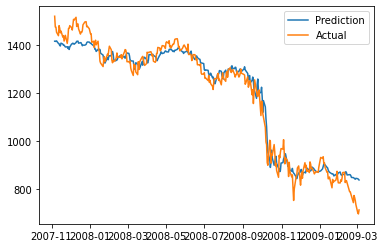

In [596]:
prediction = model.predict(x_train).flatten()
plt.plot(dates_train, prediction)
plt.plot(dates_train, y_train)
plt.legend(['Prediction', 'Actual'])